In [1]:
import numpy as np

## Neural network architecture
We will be implementing the following simple neural network architecture in this notebook.

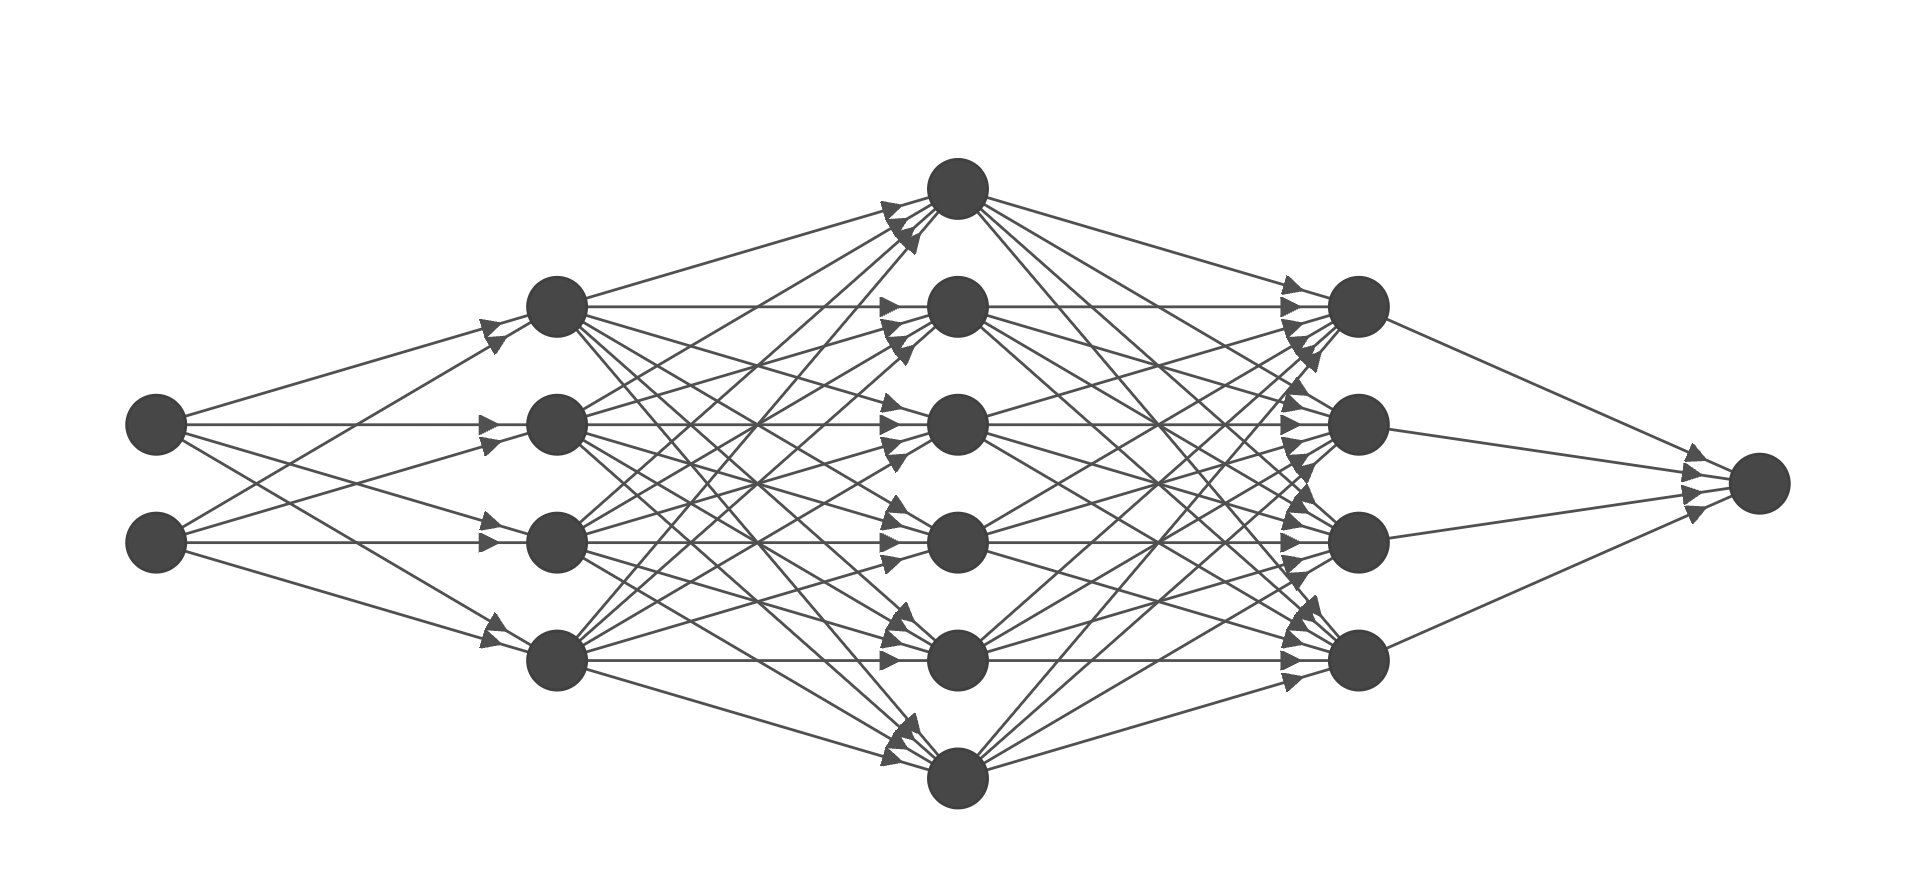

(image created with: https://alexlenail.me/NN-SVG/)

## Parameter initialization

In [647]:
# Define the neural network architecture in dictionaries
nn_arch = [
    {"input_dim": 2, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 6, "activation": "relu"},
    {"input_dim": 6, "output_dim": 4, "activation": "relu"},
    {"input_dim": 4, "output_dim": 1, "activation": "sigmoid"},
]

**Zero initialization**

Initializing the weights and biases as zero causes neurons to perform the same calculation in every iterations and produces the same outputs, and therefore is useless.

**Random initialization**

Random initialization breaks the issue of symmetry of zero initialization, however, intializing with too large (exploding gradient) or too small values (vanishing gradient) can result in slow optimization. 
If weights are initialized with large values, then Z (=wx+b) becomes too large that after applying the activation function, always map to 1, causing the neural network to take forever to train due to slow change in gradient. The use of **small values increases the efficiency of our algorithm during first iterations**. The sigmoid activation function reaches the highest derivative value for numbers close to zero, which has significant effect on the speed of training. Parameter initiation using small random numbers is a simple yet powerful approach.

**He initialization / Xavier initialization**

The methods are the common recommended weights initialization approach. Both methods use scalings factors for the random weights and biases. 
- Xavier: sqrt(1/layers_dims[l-1])
- He: sqrt(2/layers_dims[l-1])

However for simplicity, this notebook will use random initialization with a 0.1 scaling factor.

In [695]:
# Parameter values in a dictionary to store all the weights & biases of each layer of the neural network
def init_params(nn_arch, seed=123):
    np.random.seed(seed)
    parameters = {} # initialize the dictionary
    
    for i, layer in enumerate(nn_arch):
        n_layer = i + 1
        input_dim = layer['input_dim']
        output_dim = layer['output_dim']
        
        # Initialize weights & biases with low value random values
        parameters['W' + str(n_layer)] = np.random.randn(output_dim, input_dim) * 0.1 
        parameters['b' + str(n_layer)] = np.random.randn(output_dim, 1) * 0.1

    return parameters

## Activation functions
1. Sigmoid
2. Relu (rectified linear unit)

##### Sigmoid function
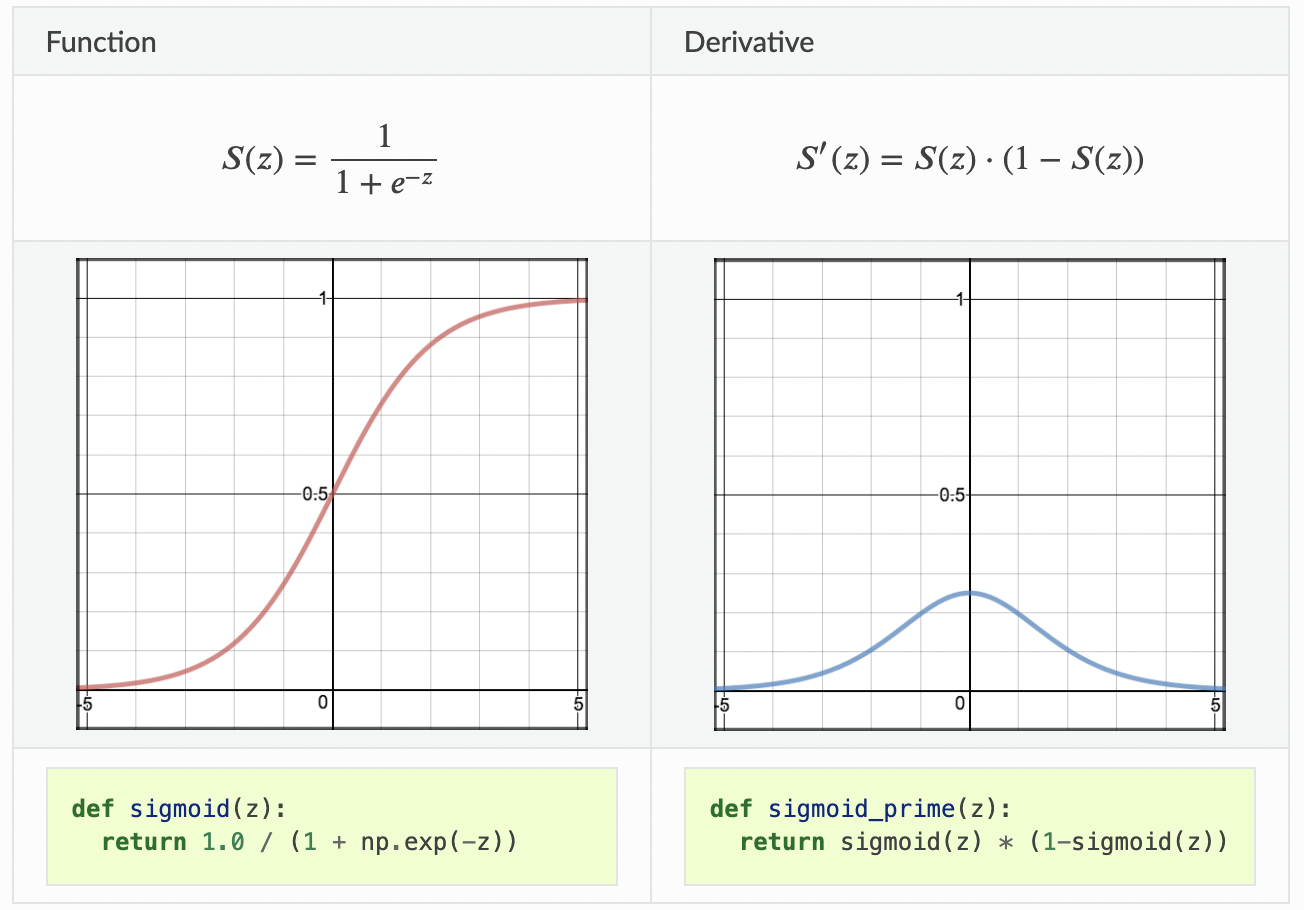


##### Relu function
The gradient of ReLU is 1 for x>0 and 0 for x<0. If the value is 1, the gradient is back propagated as it is. If it is 0, then no gradient is backpropagated.

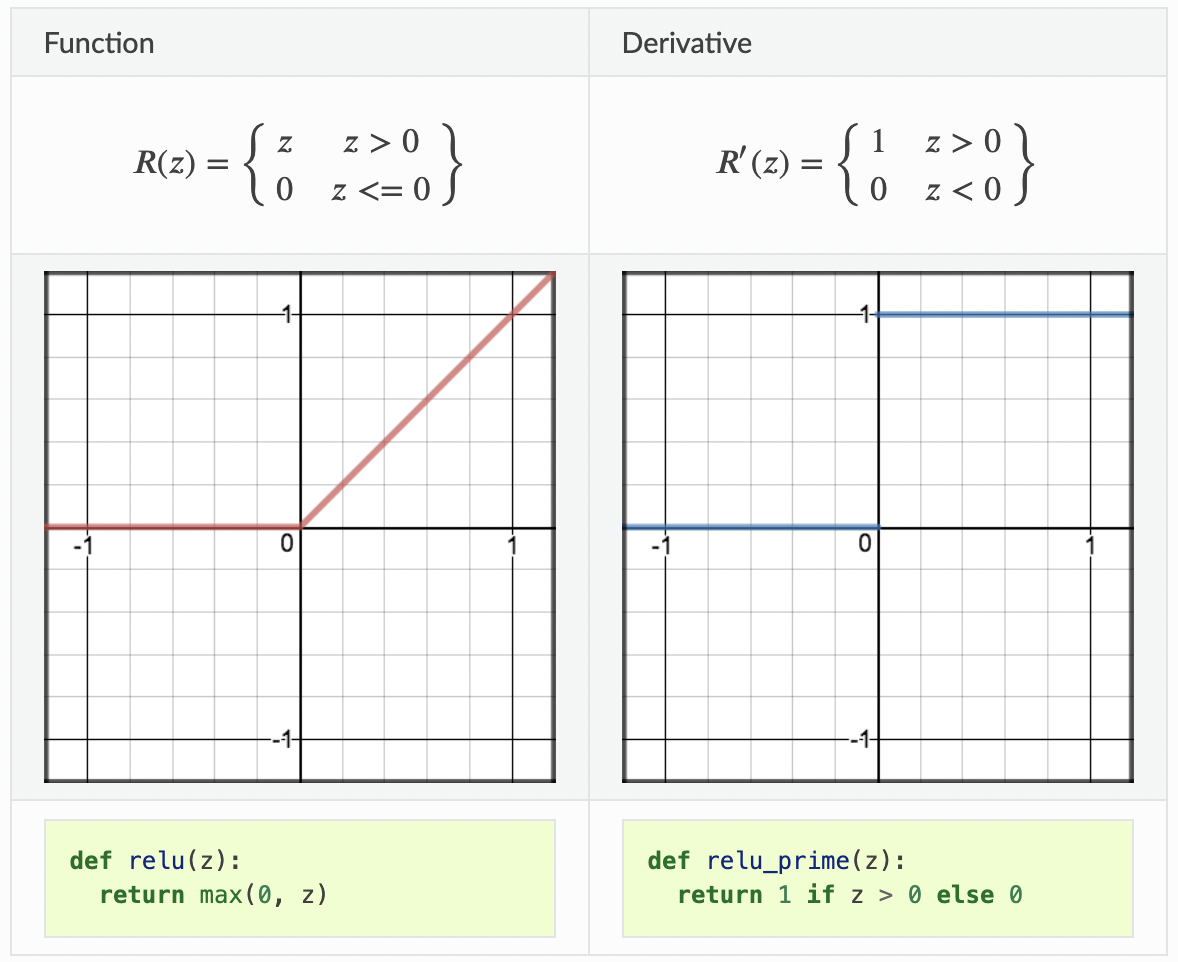

（https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html）



In [651]:
# Sigmoid function
def sigmoid(Z):
    return 1 / (1+np.exp(-Z))

def sigmoid_prime(Z):
    sig = sigmoid(Z)
    return sig * (1-sig)

# Relu function
def relu(Z):
    return np.maximum(0, Z)

def relu_prime(Z):
    return np.where(Z>0, 1, 0)


## Forward propagation

In [652]:
def single_layer_forward(A_prev, W_curr, b_curr, activation='relu'):
    Z_curr = np.dot(W_curr,A_prev) + b_curr

    if activation == 'relu':
        activation_func = relu
    elif activation == 'sigmoid':
        activation_func = sigmoid     
    A_curr = activation_func(Z_curr)
    return A_curr, Z_curr

In [653]:
def full_forward_propagation(X, parameters, nn_arch):
    """Return the final output y_pred; and
    a dictionary object containing the Z and A of each layer."""
    cache = {}
    A_curr = X # the initial input X
    
    # Loop through each layer of the NN architecture
    for ix, layer in enumerate(nn_arch): 
        n_layer = ix + 1
        A_prev = A_curr
        activation = layer['activation']
        W_curr = parameters['W' + str(n_layer)]
        b_curr = parameters['b' + str(n_layer)]
        A_curr, Z_curr = single_layer_forward(A_prev, W_curr, b_curr, activation)
        
        cache['A' + str(n_layer-1)] = A_prev # input A
        cache['Z' + str(n_layer)] = Z_curr # output Z
        
    return A_curr, cache

## Loss function
We will use the **cross binary entropy** as our loss function. Defining the loss function is the essential first step for back propagation as it tells us how to update the weights and biases through different layers of the neural net.

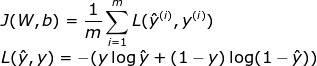

In [654]:
def loss(y_pred, y):
    m = y_pred.shape[-1] # for averaging out the loss
    loss = -1/m * (np.dot(y, np.log(y_pred).T) + np.dot(1 - y, np.log(1 - y_pred).T))
    return np.squeeze(loss)

Taking derivative of the loss function with respect to the prediction, i.e. y hat, we have:

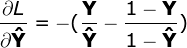

## Accuracy function
We'll use the simplest possible accuracy metric, i.e. the no. of correctly-predicted instances out of all instances. Other common metrics for evaluating binary classification  are precision and recall, confusion matrix, etc.

In [655]:
def accuracy(y_pred, y):
    y_class = np.where(y_pred>0.5, 1, 0)
    accuracy = (y_class == y).sum().mean()
    return accuracy

## Backward propagation

Backpropagation is about understanding how changing the weights and biases in a network changes the cost function. Ultimately, this means computing the partial derivatives of the loss function with respect to the weights and baises, i.e. ∂C/∂w and ∂C/∂b.

However, since the cost function does not directly relates to the weights (Wi) & biases (Bi), we could apply chain rule to compute ∂C/∂w and ∂C/∂b. Below shows the maths of the output layer.

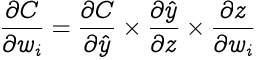

We need to find the following 3 gradients in order to compute ∂C/∂w:
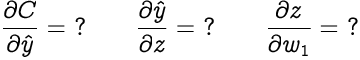

Below provides a simple illustration for getting a better intuition about the maths and concepts behind backward propagation.

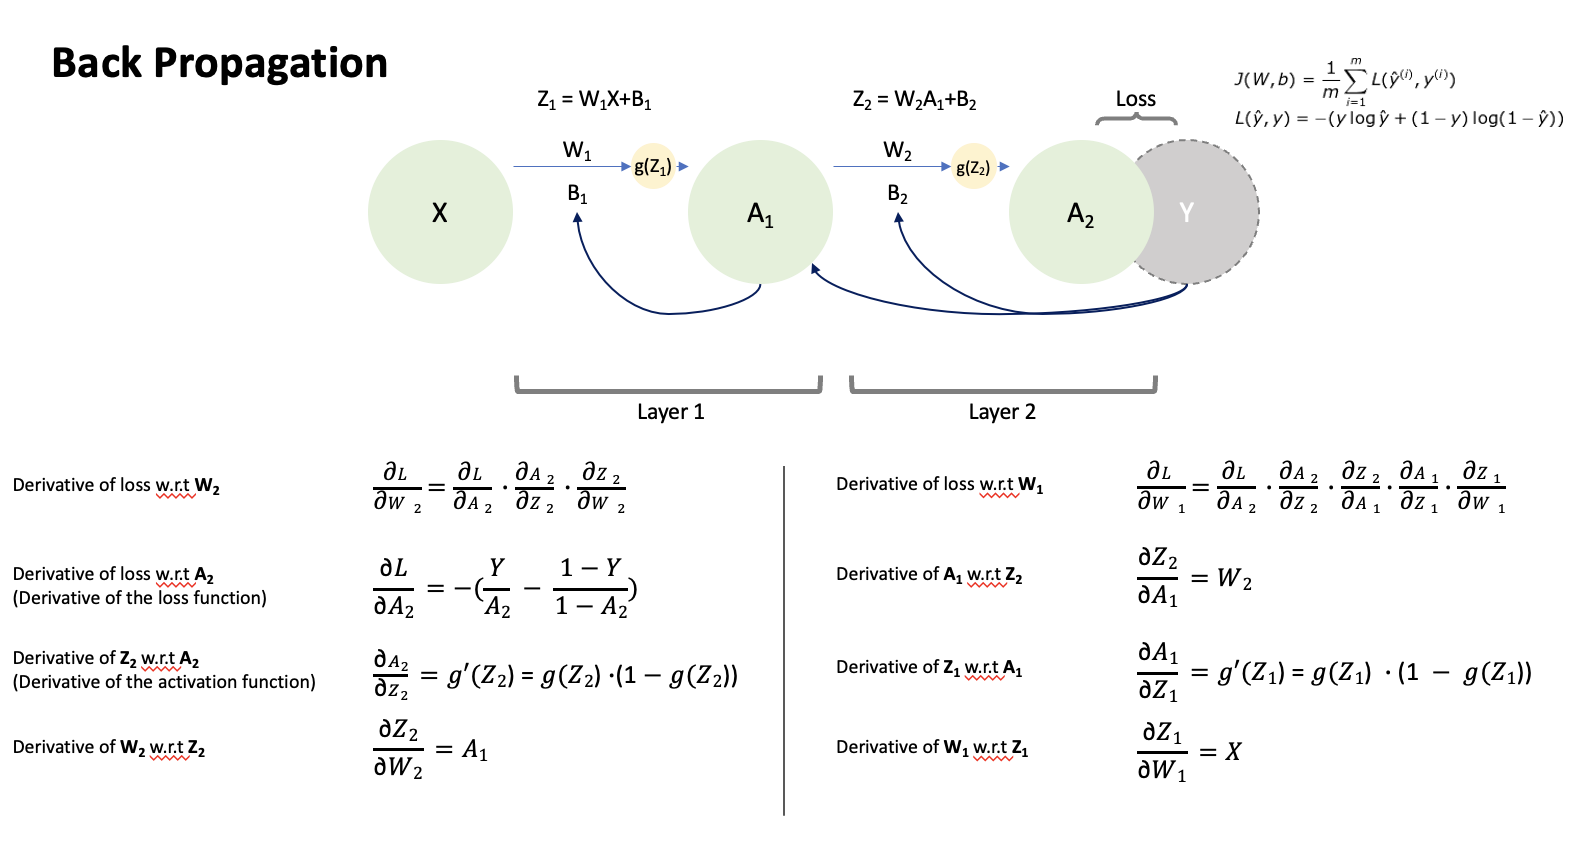

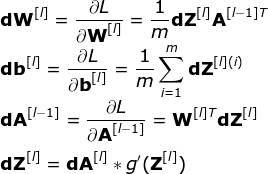

In each backward propagation, besides returning dW and db which will be used to udpate the parameter values of the neural net (the weights & biases), it should also return the previous layer's error dA_prev, which is used as an input in computing the dW & db of the previous layer.

In [656]:
def single_layer_backward(dA_curr, A_prev, W_curr, b_curr, Z_curr, activation="relu"):
    m = A_prev.shape[-1]
    if activation == "relu":
        back_activation_func = relu_prime
    elif activation == "sigmoid":
        back_activation_func = sigmoid_prime
    
    dZ_curr = dA_curr * back_activation_func(Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)
    
    return dA_prev, dW_curr, db_curr

In [657]:
def full_backward_propagation(y_pred, y, cache, parameters, nn_arch):
    """Return the gradients values dW & db for each layer."""
    gradients = {}
    y = y.reshape(y_pred.shape) # To ensure y_pred and y are of the same shape just in case
   
    # Take the derivative of loss w.r.t output as the starting point of backpropagation
    dA_prev = - (np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))
    
    # Enumerate object is not reversible, need to turn it into a list first
    for layer_ix, layer in reversed(list(enumerate(nn_arch))):
        layer_ix = layer_ix + 1
        activation = layer["activation"]
        
        dA_curr = dA_prev
        A_prev = cache["A" + str(layer_ix-1)]
        Z_curr = cache["Z" + str(layer_ix)]
        W_curr = parameters["W" + str(layer_ix)]
        b_curr = parameters["b" + str(layer_ix)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward(dA_curr, A_prev, W_curr, b_curr, Z_curr, activation)
        gradients["dW" + str(layer_ix)] = dW_curr
        gradients["db" + str(layer_ix)] = db_curr
    
    return gradients

In [658]:
# Update weights and biases of the parameters dictionary based on the gradients
def update_parameters(gradients, parameters, nn_arch, learning_rate=0.001):
    for layer_ix in range(len(nn_arch)):
        layer_ix = layer_ix + 1
        parameters['W' + str(layer_ix)] -= learning_rate * gradients["dW" + str(layer_ix)]
        parameters['b' + str(layer_ix)] -= learning_rate * gradients["db" + str(layer_ix)]
        
    return parameters        

## Training

In [689]:
def train(X, y, nn_arch, epochs=100, learning_rate=0.001):
    parameters = init_params(nn_arch)
    loss_history = []
    acc_history = []
    
    for epoch in range(epochs):
        y_pred, cache = full_forward_propagation(X, parameters, nn_arch)
        cost = loss(y_pred, y)
        loss_history.append(cost)
        acc = accuracy(y_pred, y)
        acc_history.append(acc)
        
        gradients = full_backward_propagation(y_pred, y, cache, parameters, nn_arch)
        parameters = update_parameters(gradients, parameters, nn_arch, learning_rate=learning_rate)
    
    return parameters, loss_history, acc_history
    

## Test out the neural network

In [281]:
import pandas as pd
from sklearn.datasets import load_iris

In [282]:
# Read in the iris dataset 
data = load_iris()
df = pd.DataFrame(data['data'], columns = data['feature_names'])
df['target'] = data['target']

# Only use data of 2 species for binary classification
df = df[df.target<=1]

In [556]:
X = df.iloc[:,:4].to_numpy()
y = df.iloc[:,4].to_numpy()

In [696]:
%%time
# Define the neural network architecture in dictionaries
nn_arch = [
    {"input_dim": 4, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 8, "activation": "relu"},
    {"input_dim": 8, "output_dim": 1, "activation": "sigmoid"},
]

parameters, loss_history, acc_history = train(X.T, y.reshape(1,-1), nn_arch, epochs=5000, learning_rate=0.01)


CPU times: user 992 ms, sys: 7.2 ms, total: 999 ms
Wall time: 999 ms


In [697]:
acc_history[-1]

93.0

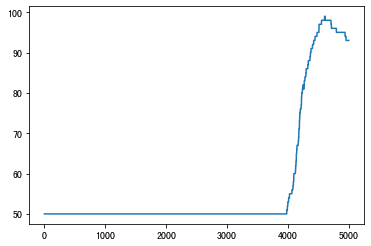

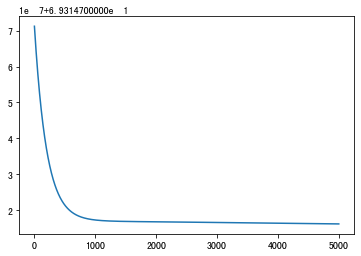

In [700]:
import matplotlib.pyplot as plt

plt.plot(acc_history)
plt.show()

plt.plot(loss_history)
plt.show()